# Step 0: Load The Data

In [96]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

import csv

label2Name = {}
with open('./data/signnames.csv') as namesFile:
    nameReader = csv.reader(namesFile)
    for row in nameReader:
        label2Name[int(row[0])] = row[1]

# Step1: Dataset Summary & Exploration

## General numbers

In [97]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(list(y_train) + list(y_valid) + list(y_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


## Image samples

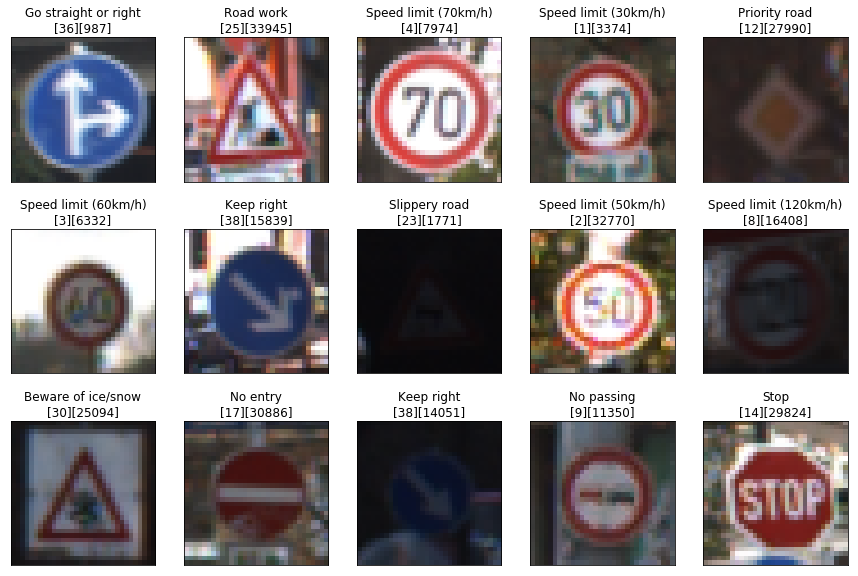

In [98]:
import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def exploreData(images, labels, translation):
    """
    Visualize a random selection of images from `images`. 
    Showing the index and the label on the image title as:
    SIGNAL_NAME
    [label value][index value]
    """
    imgLength = len(images)
    assert(imgLength == len(labels))
    columns = 5
    rows = 3    
    imgW, imgH, _ = images[0].shape
    fig, axes = plt.subplots(rows, columns, figsize=(15,10),
                         subplot_kw={'xticks': [], 'yticks': []})
   
    indexes = list(random.randint(0, imgLength) for r in range(columns * rows))
    labelLimit = 25
    for ax, index in zip(axes.flat, indexes):
        ax.imshow(images[index])
        label = labels[index]
        name = translation[label]
        if len(name) > labelLimit - 3:
            name = name[:labelLimit - 3] + '...'
        ax.set_title("{1}\n[{2}][{0}]".format(index, name, label))


exploreData(X_train, y_train, label2Name)    


## Label distribution

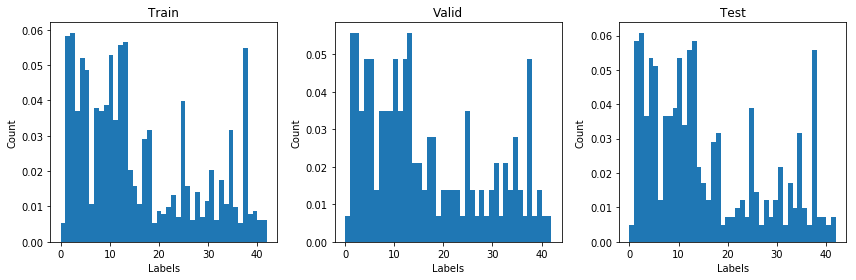

In [99]:
def plotLabelHistogram(labels, titles, numberOfLabels):
    """
    Plot the histogram of the list of `labels` using the `titles` as title for the graphs
    and the number of bins `numberOfLabels`.
    """
    nCols = len(labels)
    assert(nCols == len(titles))
    
    fig, axes = plt.subplots(ncols=nCols, figsize=(4*nCols, 4))
    for ax, label, title in zip(axes, labels, titles):        
        n, bins, patches = ax.hist(label, numberOfLabels, normed=1)
        ax.set_xlabel('Labels')
        ax.set_ylabel('Count')
        ax.set_title(title)
        
    fig.tight_layout()
    plt.show()
    
plotLabelHistogram([y_train, y_valid, y_test], ['Train', 'Valid', 'Test'], n_classes)

# Train image generation

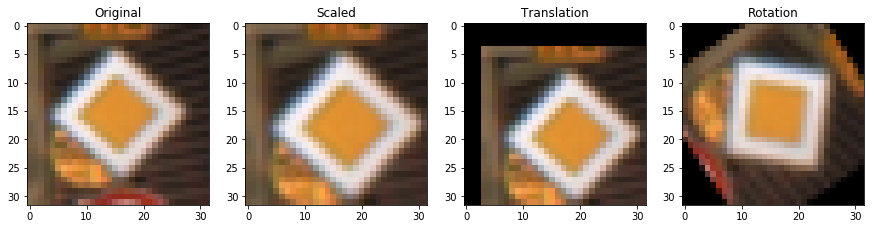

In [100]:
import cv2        
def transform(img, type = 0):
    if type == 0:
        fx = random.uniform(1.0, 1.3)
        fy = random.uniform(1.0, 1.3)
        return cv2.resize(img,None,fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)[0:32, 0:32,:]
    
    if type == 1: # Translation
        rY = random.randint(-5, 5)
        rX = random.randint(-5, 5)
        M = np.float32([[1,0,rY],[0,1,rX]])
    else:
        angle = random.randint(-90, 90)
        M = cv2.getRotationMatrix2D((16,16),angle,1)
    
    return cv2.warpAffine(img,M,(32,32))

fig, axes = plt.subplots(ncols=4, figsize=(15,10))
randomIndex = random.randint(0, len(X_train))
axes[0].imshow(X_train[randomIndex])
axes[0].set_title('Original')
axes[1].imshow(transform(X_train[randomIndex], 0))
axes[1].set_title('Scaled')
axes[2].imshow(transform(X_train[randomIndex], 1))
axes[2].set_title('Translation')
axes[3].imshow(transform(X_train[randomIndex], 2))
axes[3].set_title('Rotation')

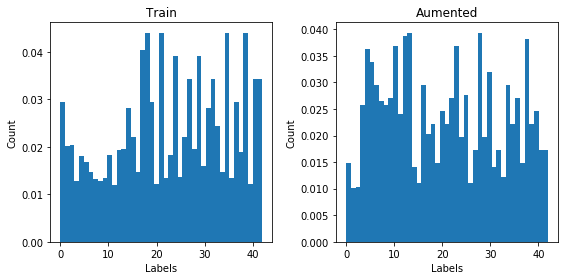

In [110]:
def generateImages(input, input_labels):
    hist, _ = np.histogram(input_labels, 43, normed=True)
    selectedLabel = []
    for index, v in enumerate(hist):
        if v < 0.02:
            selectedLabel.append(index)
    newInput = []
    newLabels = []
    for index, label in enumerate(input_labels):
        if label in selectedLabel:
            for i in range(0,3):
                type = random.randint(0, 3)
                newLabels.append(label)
                newInput.append(transform(input[index], type))
    
    return (np.array(newInput), np.array(newLabels))

X_train_new, y_train_new = generateImages(X_train, y_train)
added = np.concatenate((y_train, y_train_new), axis=0)
plotLabelHistogram([y_train, added], ['Train', 'Aumented'], n_classes)
X_train = np.concatenate((X_train, X_train_new), axis=0)
y_train = np.concatenate((y_train, y_train_new), axis=0)

# Step 2: Design and Test a Model Architecture

## Pre-processing

In [5]:
noNormalized = { \
                 "input": X_train, "labels": y_train, \
                 "valid_input": X_valid, "valid_labels": y_valid, \
                 "test_input" : X_test, "test_labels" : y_test
               }

In [6]:
# Simple normalization

def normalizeInput(input):    
    """
    Normalize the `input` image applying pixel - 128 / 128.
    """
    return (input - 128.0) / 128.0
    
X_train_normalized = normalizeInput(X_train)
X_valid_normalized = normalizeInput(X_valid)
X_test_normalized = normalizeInput(X_test)

normalizedImages = { \
                     "input": X_train_normalized, "labels": y_train, \
                     "valid_input": X_valid_normalized, "valid_labels": y_valid, \
                     "test_input": X_test_normalized, "test_labels": y_test
                   }


In [7]:
# Histogram equalized

def equalizeYChannel(inputs):
    """
    Equalize images in `inputs` on the Y channel only.
    Source:
    https://www.packtpub.com/mapt/book/Application-Development/9781785283932/2/ch02lvl1sec26/Enhancing%20the%20contrast%20in%20an%20image
    """
    output = inputs.copy()
    for index, img in enumerate(output):
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        output[index] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    return output

X_train_hist = normalizeInput(equalizeYChannel(X_train))
X_valid_hist = normalizeInput(equalizeYChannel(X_valid))
X_test_hist = normalizeInput(equalizeYChannel(X_test))

equalizedImages = { \
                     "input": X_train_hist, "labels": y_train, \
                     "valid_input": X_valid_hist, "valid_labels": y_valid, \
                     "test_input": X_test_hist, "test_labels": y_test
                   }
   

In [8]:
# Gray scale after equalized
def toGray(inputs):
    """
    Convert the images in `input` to gray scale
    """
    output = inputs.copy()
    for index, img in enumerate(output):
        output[index] = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
    
    return output

X_train_gray = normalizeInput(toGray(equalizeYChannel(X_train)))
X_valid_gray = normalizeInput(toGray(equalizeYChannel(X_valid)))
X_test_gray = normalizeInput(toGray(equalizeYChannel(X_test)))

grayImages = { \
                     "input": X_train_gray, "labels": y_train, \
                     "valid_input": X_valid_gray, "valid_labels": y_valid, \
                     "test_input": X_test_gray, "test_labels": y_test
                   }

In [9]:
# Single channel gray
def toGraySingle(inputs):
    output = np.zeros((len(inputs), 32, 32, 1), np.float64)
    for index, img in enumerate(inputs):
        output[index] = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).reshape(32,32,1)
    return output


X_train_gray_single = normalizeInput(toGraySingle(equalizeYChannel(X_train)))
X_valid_gray_single = normalizeInput(toGraySingle(equalizeYChannel(X_valid)))
X_test_gray_single = normalizeInput(toGraySingle(equalizeYChannel(X_test)))

singleGrayImages = { \
                     "input": X_train_gray_single, "labels": y_train, \
                     "valid_input": X_valid_gray_single, "valid_labels": y_valid, \
                     "test_input": X_test_gray_single, "test_labels": y_test
                   }

## Model Architecture

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

## Train, Validate and Test the Model¶

In [11]:
def train(name, net, inputs, batchSize, epochs, rate = 0.001, modelName = "", xChannels=3):
    """
    `name` identify the NN used.
    
    Trains the nn created by `net` function. Using `input` dict as:
    {
      "input"         : IMAGES_TO_TRAIN,
      "labels"        : LABELS_TO_TRAIN,
      "valid_input"   : IMAGES_TO_VALIDATE,
      "valid_labels"  : LABELS_TO_VALIDATE,
      "test_input"    : IMAGES_TO_TEST,
      "test_labels"   : LABELS_TO_TEST
    }
    
    unsing a `batchSize`, `epochs`, and learning rate `rate`.
    If the parameter `modelName` is provided, the model will be saved with that name.
    
    Returs:
    {
      "validation": VALIDATION_ACCURACY[EPOCH],
      "test" : TEST_ACCURACY
    }
    """
    input = inputs["input"]
    labels = inputs["labels"]
    valid_input = inputs["valid_input"]
    valid_labels = inputs["valid_labels"]
    test_input = inputs["test_input"]
    test_labels = inputs["test_labels"]
    
    # Placeholders 
    x = tf.placeholder(tf.float32, (None, 32, 32, xChannels))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, 43)
    
    # Create net graph
    logits = net(x)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()
    
    def evaluate(X_data, y_data, batchSize, accuracyOperator):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, batchSize):
            batch_x, batch_y = X_data[offset:offset+batchSize], y_data[offset:offset+batchSize]
            accuracy = sess.run(accuracyOperator, feed_dict={x: batch_x, y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
    epoch_validation = np.zeros((epochs), dtype=np.float64)
    test_accuracy = 0.0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(input)
        print('Training - ' + name)
        for i in range(epochs):
            input, labels = shuffle(input, labels)
            for offset in range(0, num_examples, batchSize):
                end = offset + batchSize
                batch_x, batch_y = input[offset:end], labels[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
            # Accuracy calculation
            validation_accuracy = evaluate(valid_input, valid_labels, batchSize, accuracy_operation)
            epoch_validation[i] = validation_accuracy

        if modelName != "":
            saver.save(sess, './models/' + modelName)
        
        test_accuracy = evaluate(test_input, test_labels, batchSize, accuracy_operation)

    return { \
             "name" : name, \
             "validation": epoch_validation, \
             "test" : test_accuracy
           }

def visualizeTraining(trainings):
    """
    Visualize the `trainings`. It expect each training to be a dict with the following values:
    {
      "name": TRAINING_NAME,
      "validation": VALIDATION_ACCURACY_DATA,
      "test": TEST_ACCURACY
    }
    """
    cols = len(trainings)
    fig, axes = plt.subplots(ncols=cols, figsize=(5*cols, 4))
    for ax, training in zip(axes.flat, trainings):
        y = training['validation']
        ax.plot(range(1, len(y) +1), y)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.set_title('{} Test: {:.3f}'.format(training['name'], training['test']))
        ax.grid(True, zorder=5)

# Exploring LeNet 

In [22]:
def LeNet(x, mu=0, sigma=0.1):    
    """
    Defines the network. `x` as input. 
    `mu` and `sigma`: Arguments used for tf.truncated_normal, randomly defines variables for 
                      the weights and biases for each layer
    """
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma), name='Layer1_W')
    conv1_b = tf.Variable(tf.zeros(6), name='Layer1_B')
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name='Layer2_W')
    conv2_b = tf.Variable(tf.zeros(16), name='Layer2_B')
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name='Layer3_W')
    fc1_b = tf.Variable(tf.zeros(120), name='Layer3_B')
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name='Layer4_W')
    fc2_b  = tf.Variable(tf.zeros(84), name='Layer4_B')
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name='Layer5_W')
    fc3_b  = tf.Variable(tf.zeros(43), name='Layer5_B')
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [13]:
epochs = 15
leNetNoNormalized = train('No pre-processing', LeNet, noNormalized, 128, epochs)
tf.reset_default_graph()
leNetNormalized = train('Pre-processing',LeNet, normalizedImages, 128, epochs)
tf.reset_default_graph()
leNetEqualized = train('Equalized', LeNet, equalizedImages, 128, epochs)

Training - No pre-processing
Training - Pre-processing
Training - Equalized


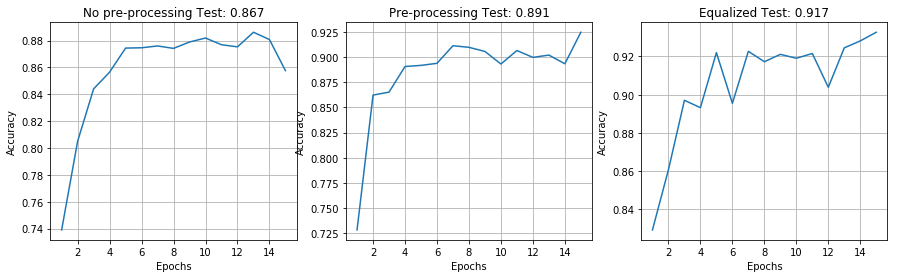

In [14]:
visualizeTraining([leNetNoNormalized, leNetNormalized, leNetEqualized])

Training - Gray


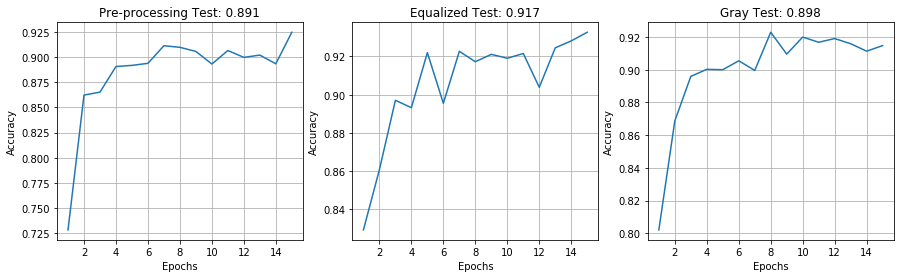

In [15]:
tf.reset_default_graph()
leNetGray = train('Gray', LeNet, grayImages, 128, epochs)
visualizeTraining([leNetNormalized, leNetEqualized, leNetGray])


# LeNet with dropouts

In [16]:
def LeNetDropouts(x, mu=0, sigma=0.1, keep_prob=0.5):    
    """
    Defines the network. `x` as input. 
    `mu` and `sigma`: Arguments used for tf.truncated_normal, randomly defines variables for 
                      the weights and biases for each layer
    `keep_prob` : Keep probability for dropout.
    """
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma), name='Layer1_W')
    conv1_b = tf.Variable(tf.zeros(6), name='Layer1_B')
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name='Layer2_W')
    conv2_b = tf.Variable(tf.zeros(16), name='Layer2_B')
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name='Layer3_W')
    fc1_b = tf.Variable(tf.zeros(120), name='Layer3_B')
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name='Layer4_W')
    fc2_b  = tf.Variable(tf.zeros(84), name='Layer4_B')
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name='Layer5_W')
    fc3_b  = tf.Variable(tf.zeros(43), name='Layer5_B')
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

Training - No pre-processing
Training - Pre-processing
Training - Equalized
Training - Gray


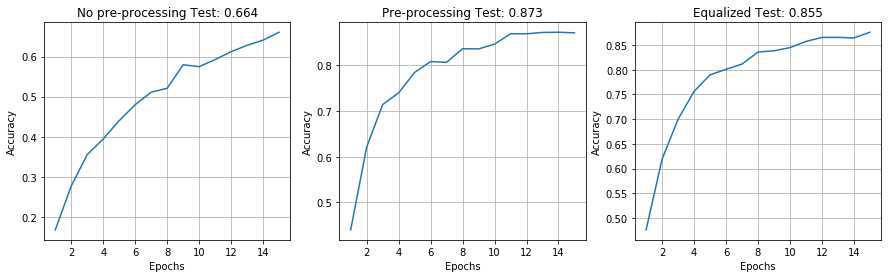

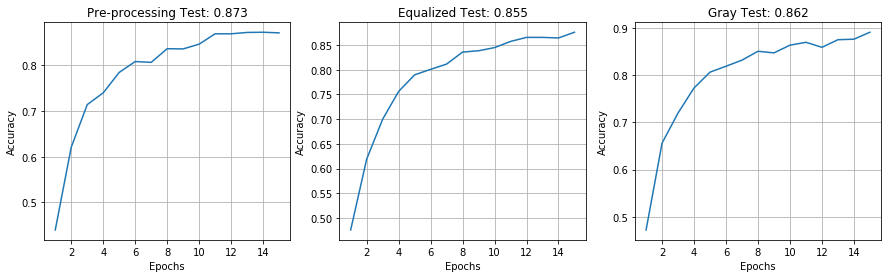

In [17]:
tf.reset_default_graph()
leNetDropoutNoNormalized = train('No pre-processing', LeNetDropouts, noNormalized, 128, epochs)
tf.reset_default_graph()
leNetDropoutNormalized = train('Pre-processing',LeNetDropouts, normalizedImages, 128, epochs)
tf.reset_default_graph()
leNetDropoutEqualized = train('Equalized', LeNetDropouts, equalizedImages, 128, epochs)
tf.reset_default_graph()
leNetDropoutGray = train('Gray', LeNetDropouts, grayImages, 128, epochs)
visualizeTraining([leNetDropoutNoNormalized, leNetDropoutNormalized, leNetDropoutEqualized])
visualizeTraining([leNetDropoutNormalized, leNetDropoutEqualized, leNetDropoutGray])

Training - No pre-processing
Training - Pre-processing
Training - Equalized
Training - Gray


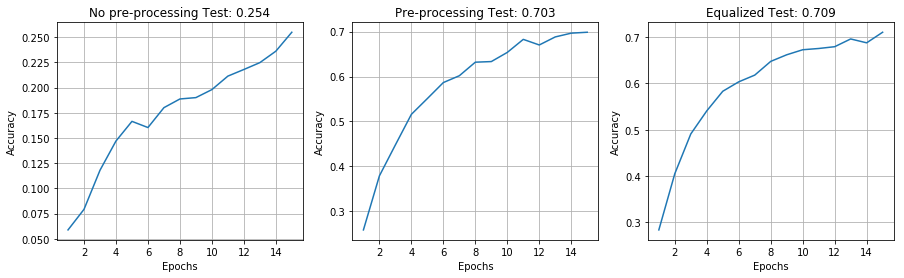

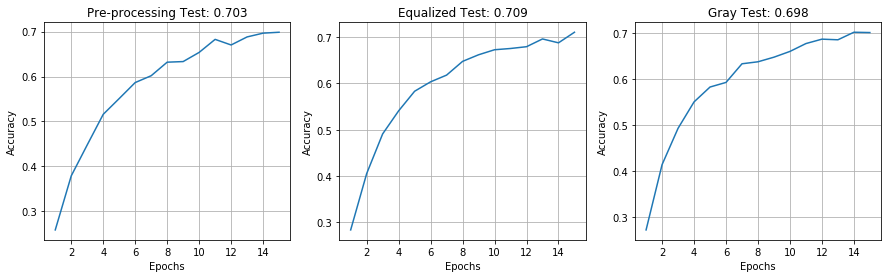

In [18]:
leNetZero3 = lambda x: LeNetDropouts(x, keep_prob=0.3)
    
tf.reset_default_graph()
leNetDropoutNoNormalized = train('No pre-processing', leNetZero3, noNormalized, 128, epochs)
tf.reset_default_graph()
leNetDropoutNormalized = train('Pre-processing',leNetZero3, normalizedImages, 128, epochs)
tf.reset_default_graph()
leNetDropoutEqualized = train('Equalized', leNetZero3, equalizedImages, 128, epochs)
tf.reset_default_graph()
leNetDropoutGray = train('Gray', leNetZero3, grayImages, 128, epochs)
visualizeTraining([leNetDropoutNoNormalized, leNetDropoutNormalized, leNetDropoutEqualized])
visualizeTraining([leNetDropoutNormalized, leNetDropoutEqualized, leNetDropoutGray])

# Single-channel LeNet

In [19]:
def LeNetSingleChannel(x, mu=0, sigma=0.1):    
    """
    Defines the network. `x` as input. 
    `mu` and `sigma`: Arguments used for tf.truncated_normal, randomly defines variables for 
                      the weights and biases for each layer
    """
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name='Layer1_W')
    conv1_b = tf.Variable(tf.zeros(6), name='Layer1_B')
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name='Layer2_W')
    conv2_b = tf.Variable(tf.zeros(16), name='Layer2_B')
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name='Layer3_W')
    fc1_b = tf.Variable(tf.zeros(120), name='Layer3_B')
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name='Layer4_W')
    fc2_b  = tf.Variable(tf.zeros(84), name='Layer4_B')
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name='Layer5_W')
    fc3_b  = tf.Variable(tf.zeros(43), name='Layer5_B')
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [20]:
tf.reset_default_graph
leNetSingleChannel = train('Single-channel', LeNetSingleChannel, singleGrayImages, 128, epochs, xChannels=1)

Training - Single-channel


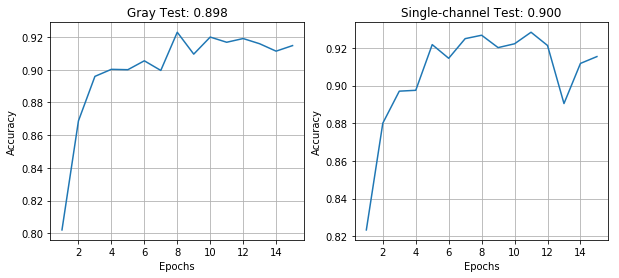

In [21]:
visualizeTraining([leNetGray, leNetSingleChannel])

# Step 3: Test a Model on New Images

# Step 4 (Optional): Visualize the Neural Network's State with Test Images